In [8]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [9]:
df = pd.read_csv('/content/train (3).csv', on_bad_lines='skip')

In [11]:
df.head()


,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


In [12]:
df.isnull().sum()

,0
date,0
store,1
item,5
sales,5


In [13]:
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1.0,1.0,13.0,2013,1,1,1
1,2013-01-02,1.0,1.0,11.0,2013,1,2,2
2,2013-01-03,1.0,1.0,14.0,2013,1,3,3
3,2013-01-04,1.0,1.0,13.0,2013,1,4,4
4,2013-01-05,1.0,1.0,10.0,2013,1,5,5


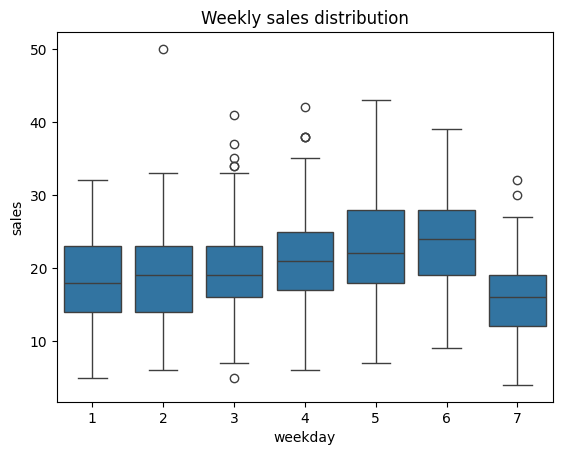

In [14]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

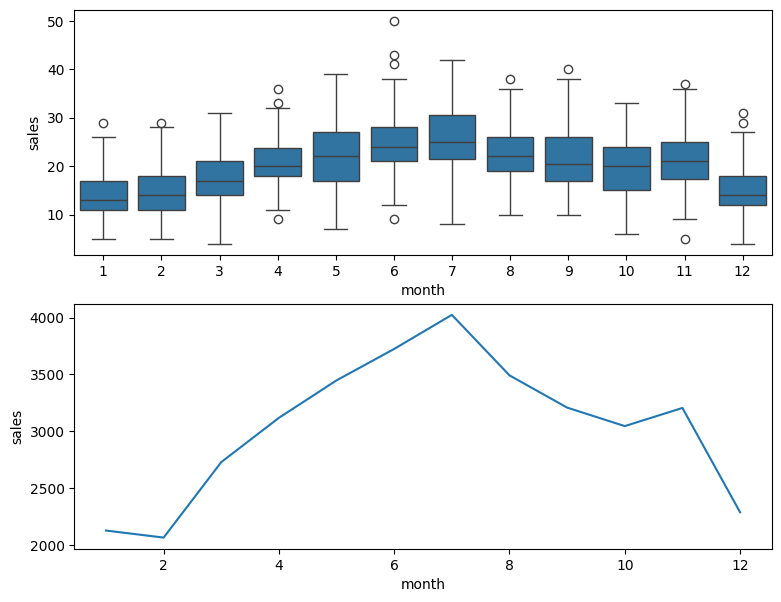

In [15]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

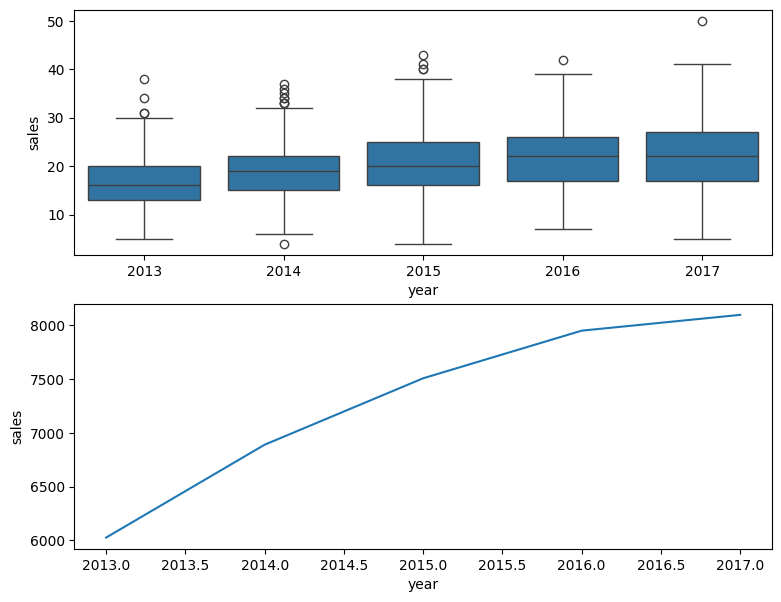

In [16]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

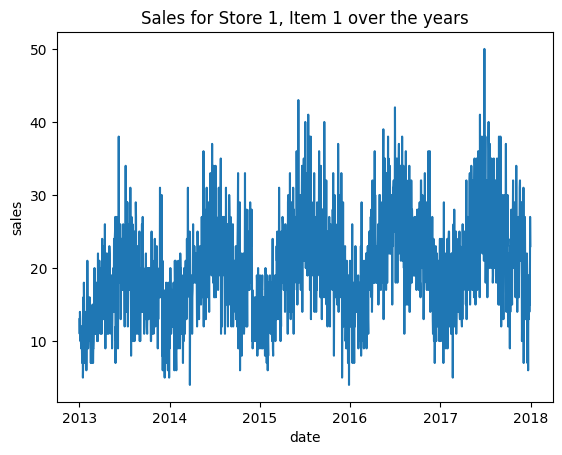

In [17]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

In [20]:

# Subtract 1 year and add 1 day using DateOffset
dates = (test_df['date'] - pd.DateOffset(years=1) + pd.Timedelta(days=1)).dt.date

# Filter the sales for the dates in the seasonal_naive_sales calculation
seasonal_naive_sales = train_df[train_df['date'].dt.date.isin(dates)]['sales']

# Create a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)

# Display the results
sn_pred_df.head()


,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1.0,1.0,2017,10,1,6,26.0
1,2017-10-02,1.0,1.0,2017,10,2,7,20.0
2,2017-10-03,1.0,1.0,2017,10,3,1,28.0
3,2017-10-04,1.0,1.0,2017,10,4,2,17.0
4,2017-10-05,1.0,1.0,2017,10,5,3,22.0


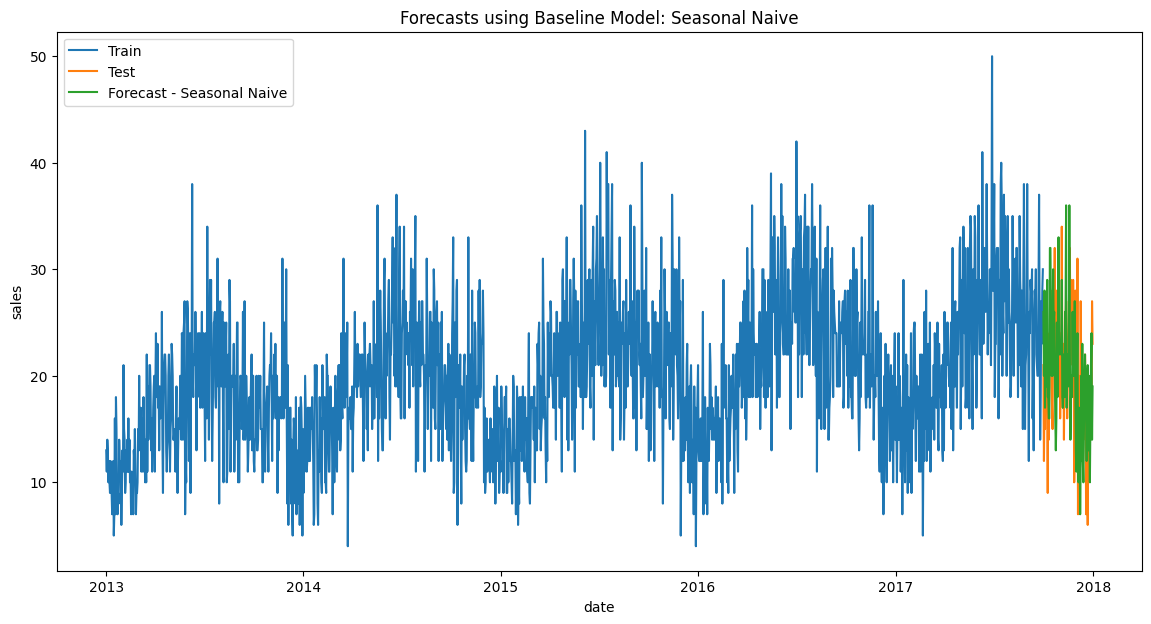

In [21]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

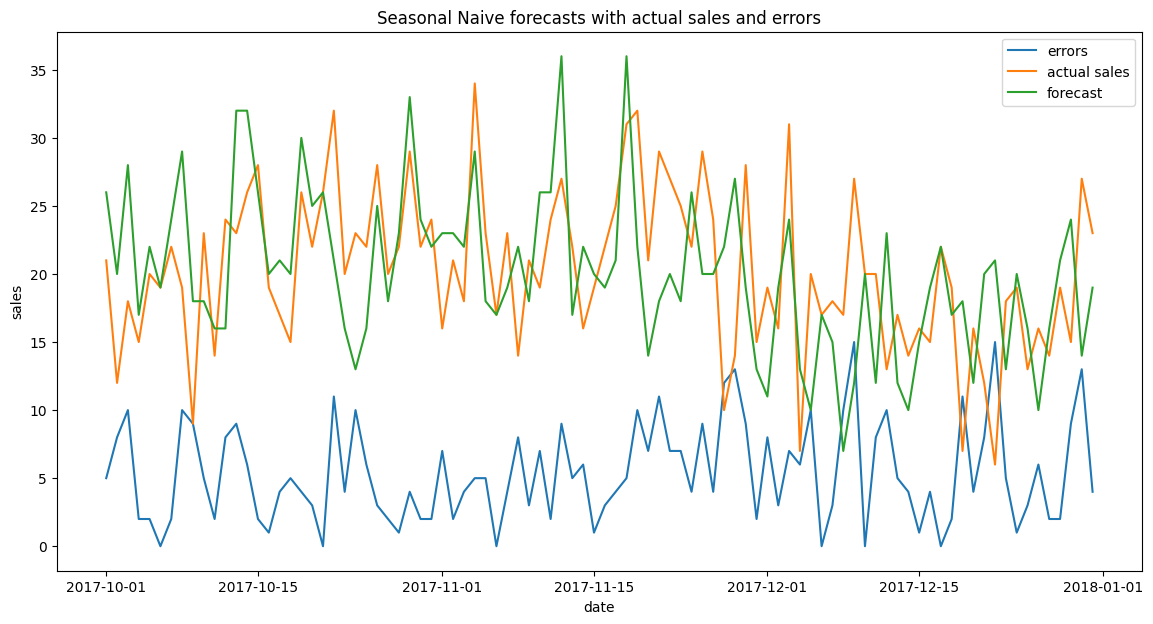

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1861.0,1851.0,10.0,5.391304,6.507521,26.652337


In [22]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))

plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

In [23]:
### Time Series Decomposition Plot

In [24]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1.0,1.0,13.0,2013,1,1,1
2013-01-02,1.0,1.0,11.0,2013,1,2,2
2013-01-03,1.0,1.0,14.0,2013,1,3,3
2013-01-04,1.0,1.0,13.0,2013,1,4,4
2013-01-05,1.0,1.0,10.0,2013,1,5,5


<Figure size 640x480 with 0 Axes>

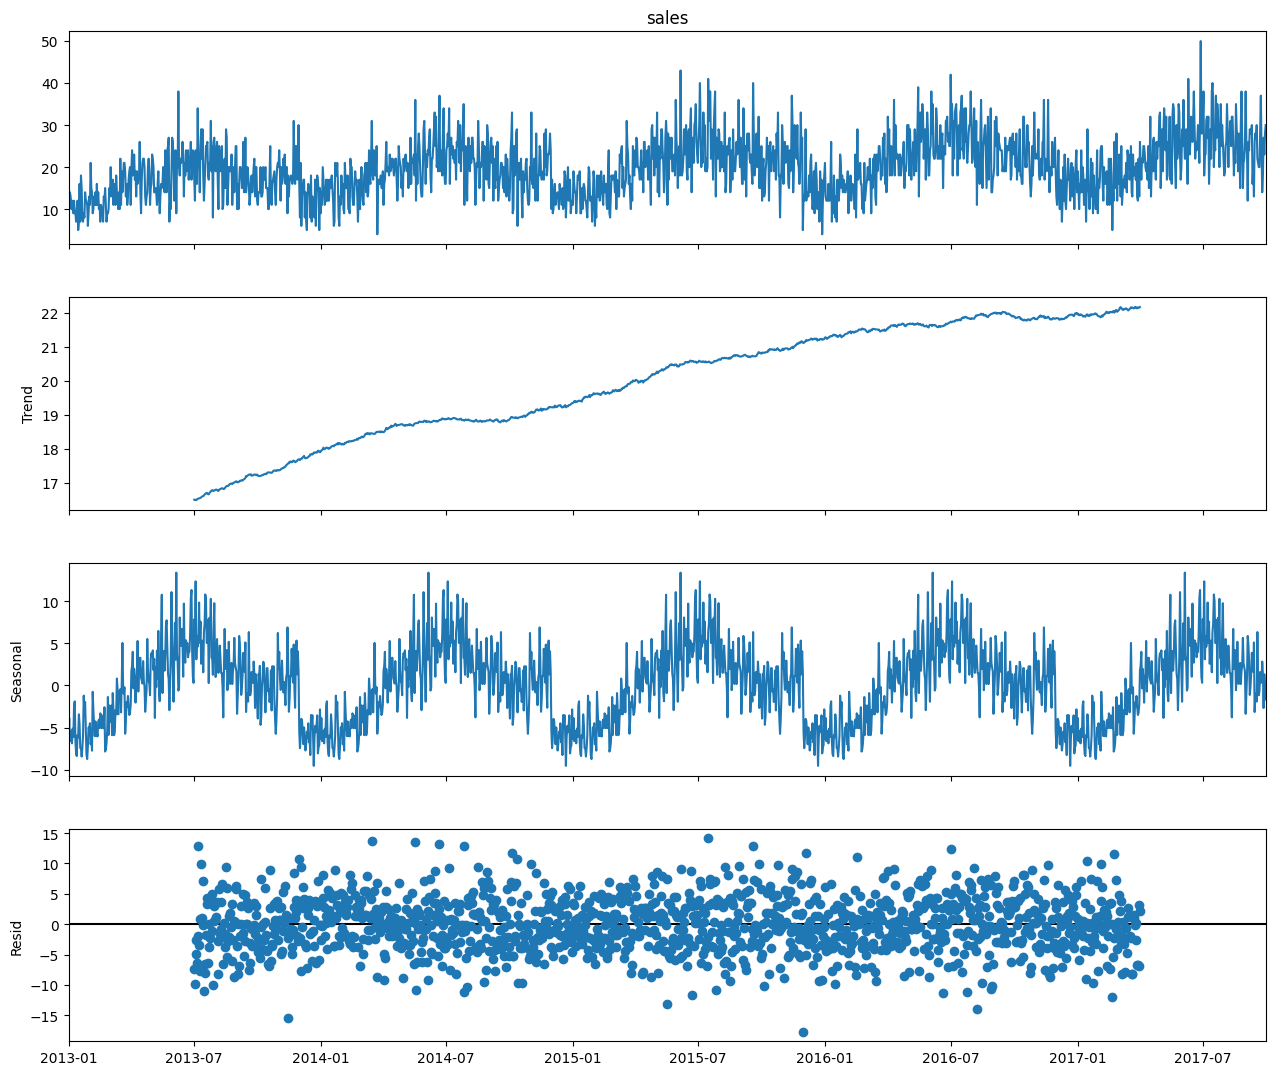

In [26]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Initialize the model with desired parameters
hw_model_1 = ExponentialSmoothing(hw_train_df,
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=12,
                                  use_boxcox=False)

# Fit the model
hw_fit_1 = hw_model_1.fit(remove_bias=False)

# Make predictions
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

pred_fit_1.head()


,index,pred_sales
0,2017-10-01,24.621840
1,2017-10-02,24.577059
2,2017-10-03,24.309157
3,2017-10-04,24.178123
4,2017-10-05,23.739227


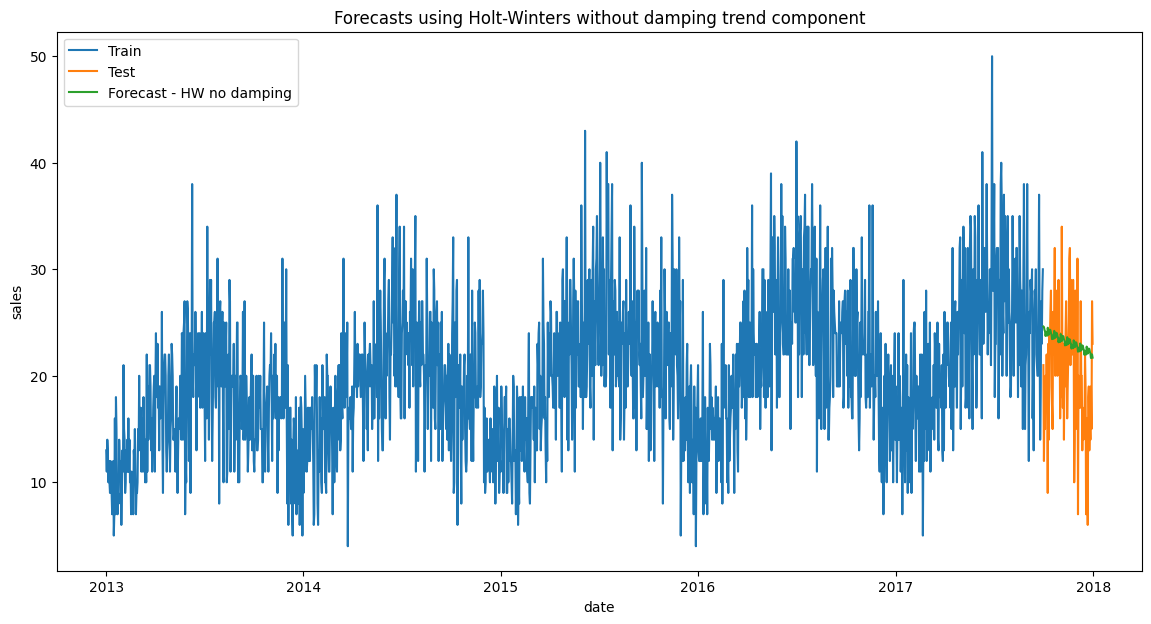

In [29]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()

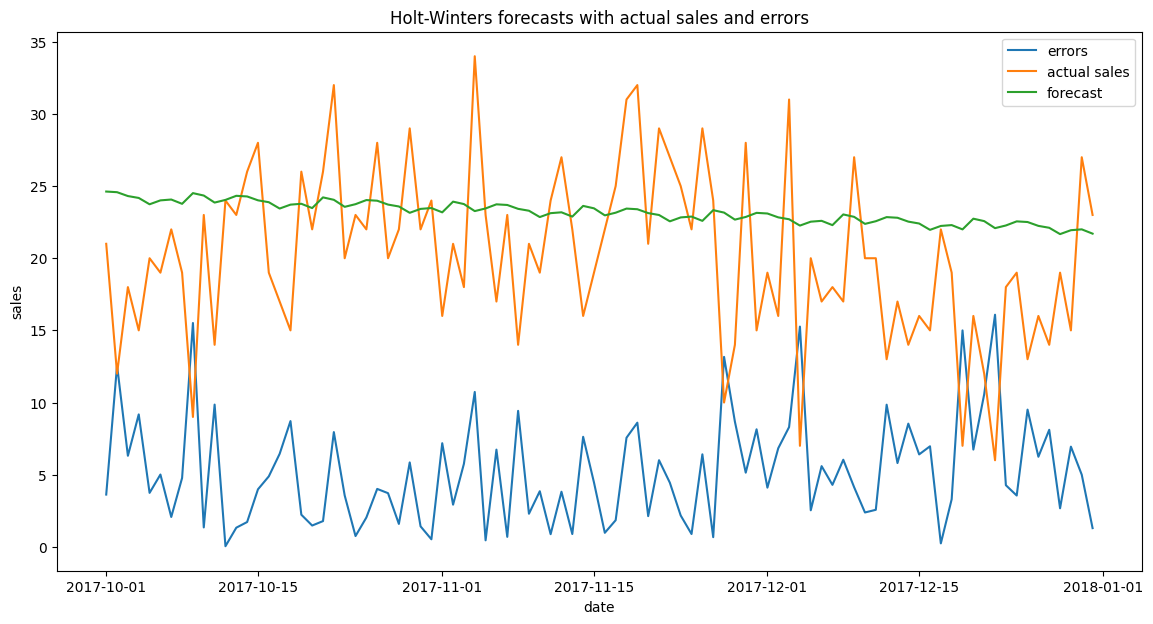

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1861.0,2132.536302,-271.536302,5.235092,6.430953,25.880088


In [30]:
plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hw

In [31]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hwd

NameError: name 'pred_fit_2' is not defined

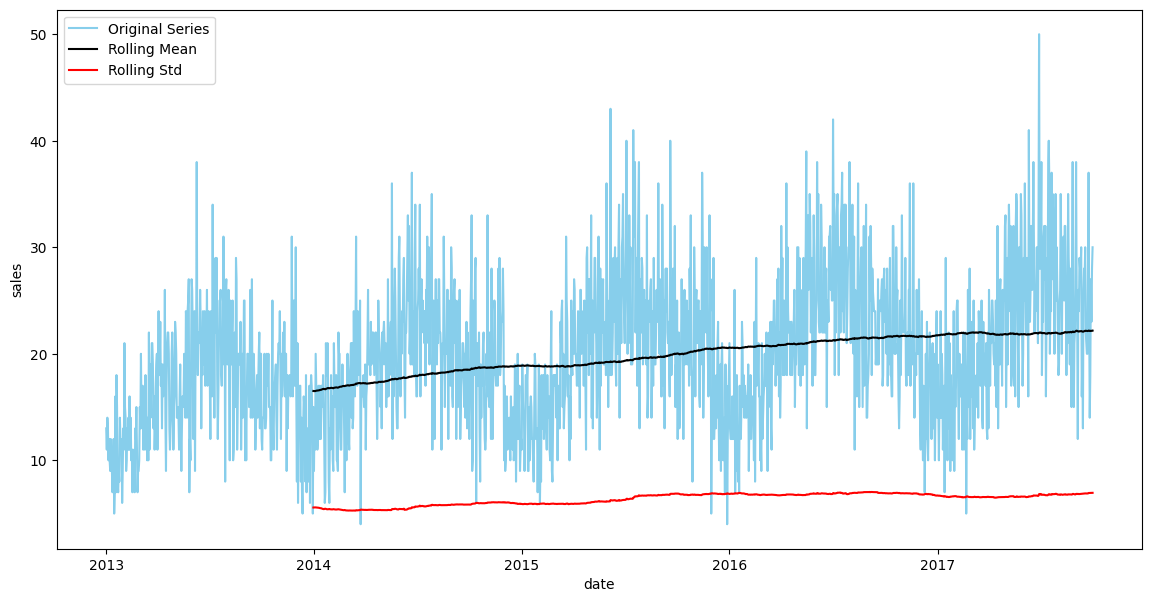

Test statistic = -2.937
P-value = 0.041
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


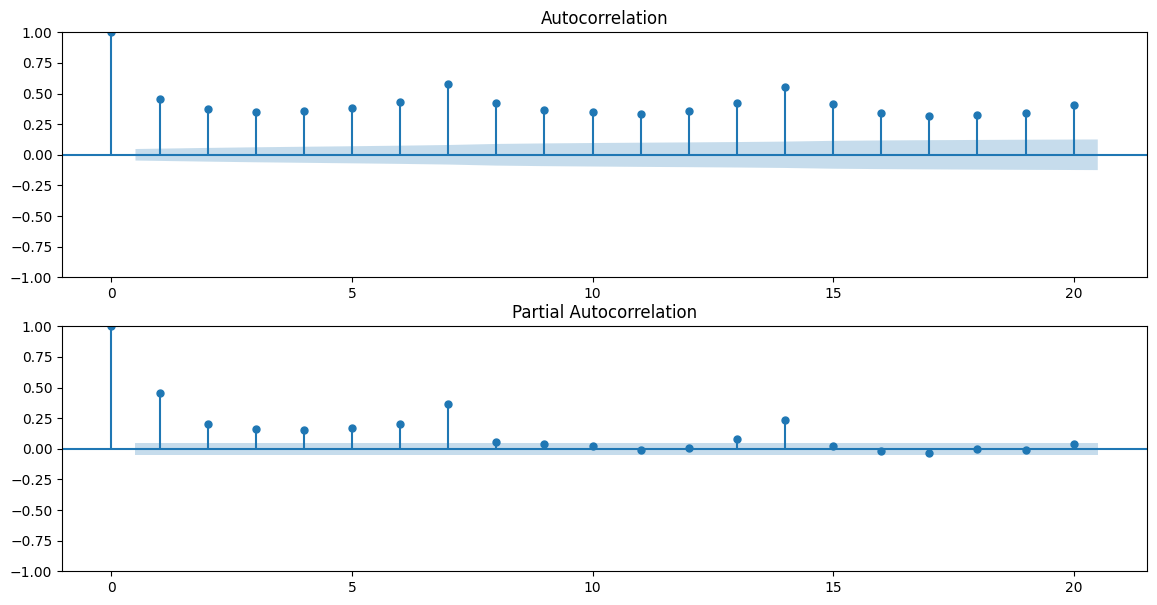

In [33]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)

test_stationarity(arima_df.sales)

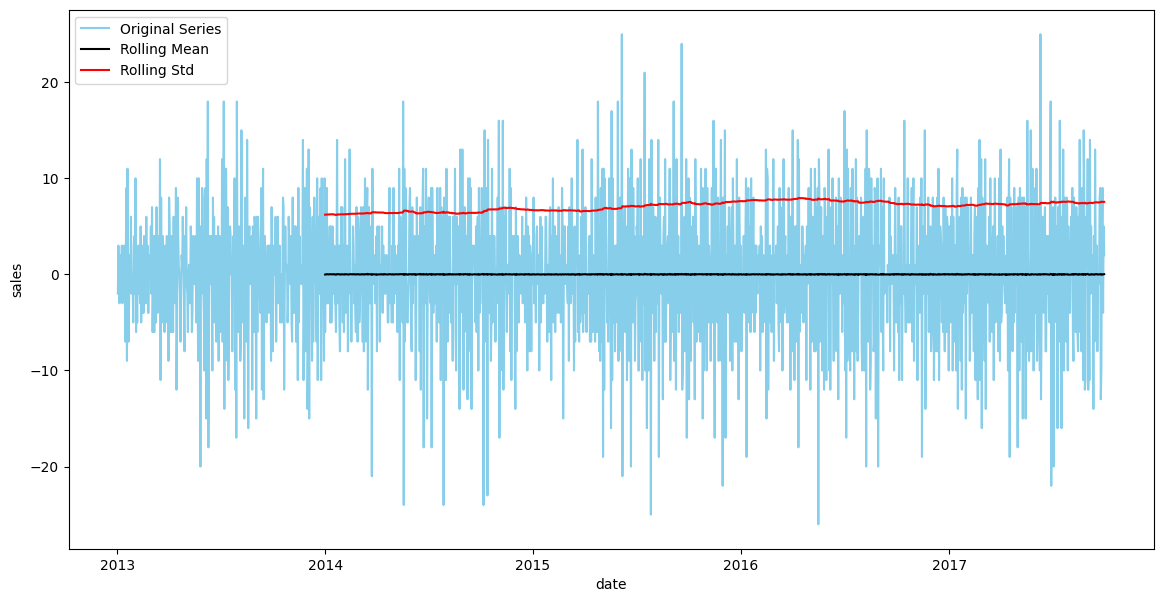

Test statistic = -12.326
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


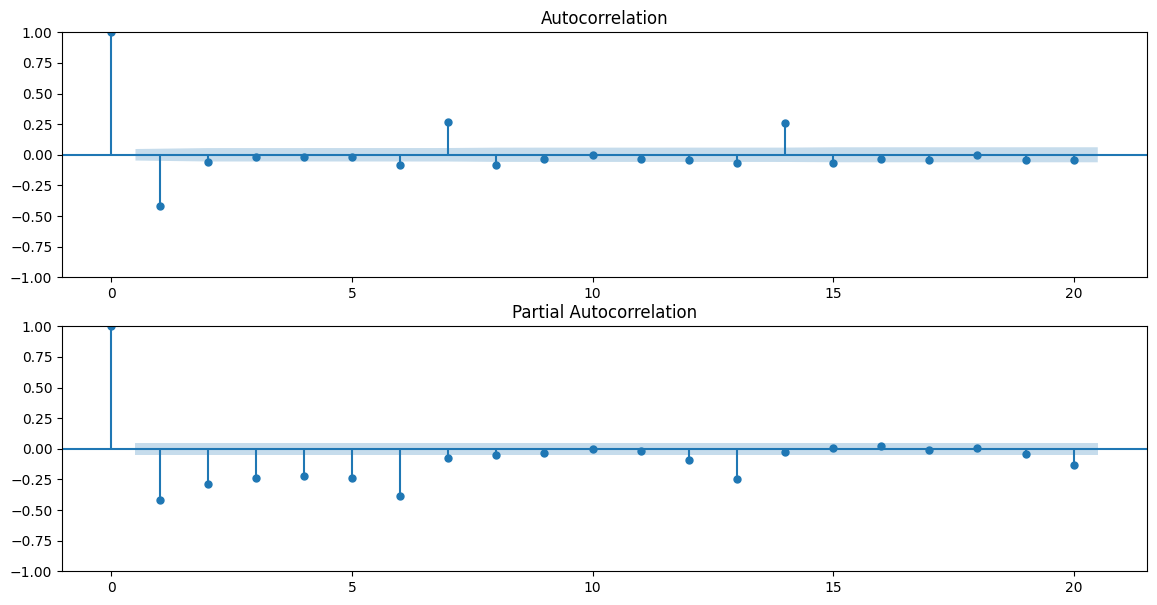

In [34]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

In [35]:
arima_model61 = ARIMA(arima_df.sales, (6,1,1)).fit(disp=False)
print(arima_model61.summary())

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [36]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

NameError: name 'arima_model61' is not defined

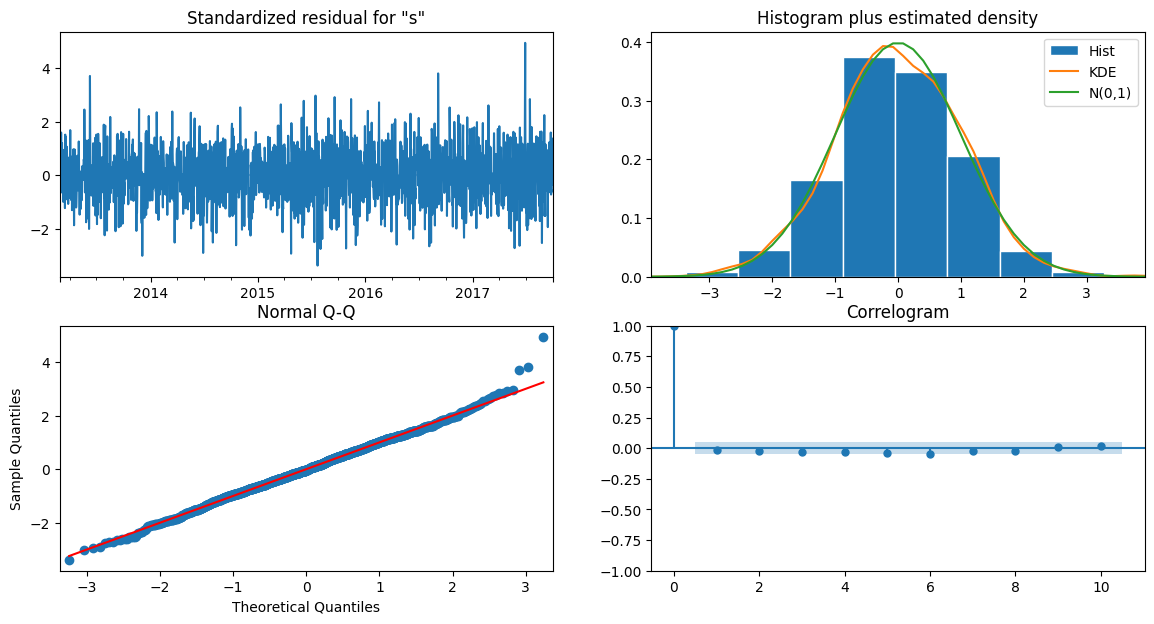

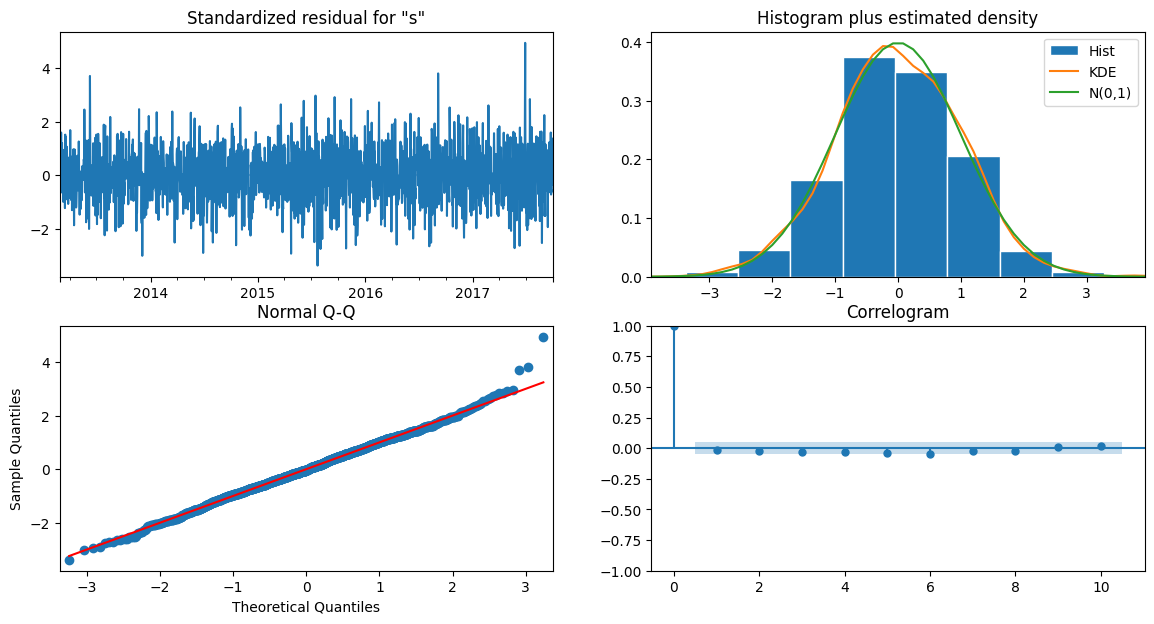

In [37]:
# fit the model
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7),
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

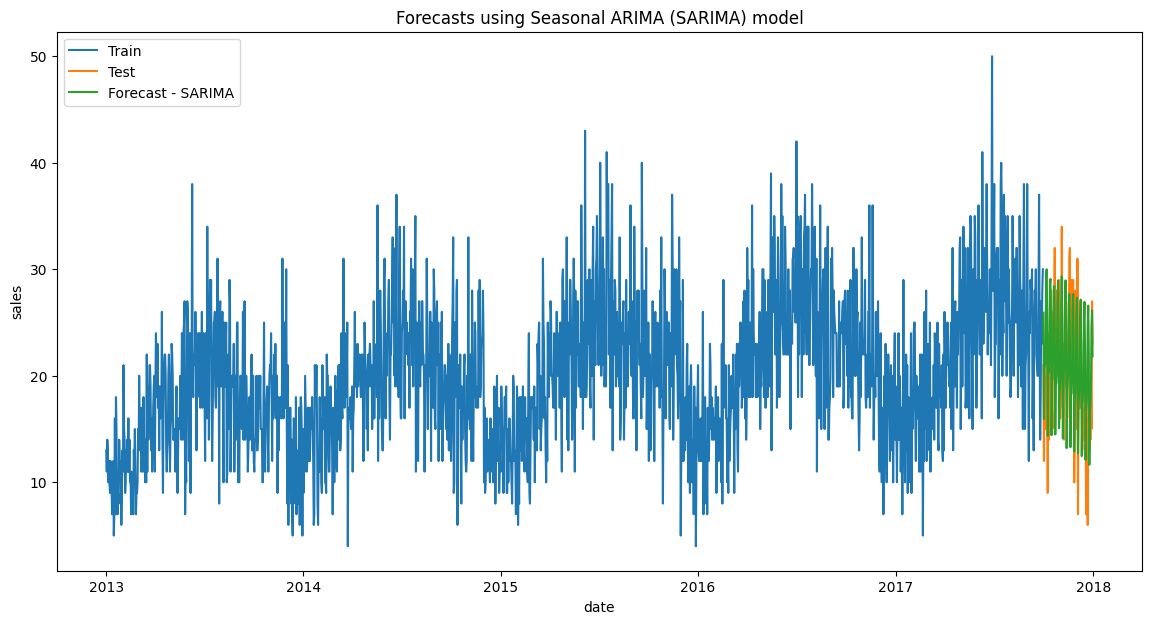

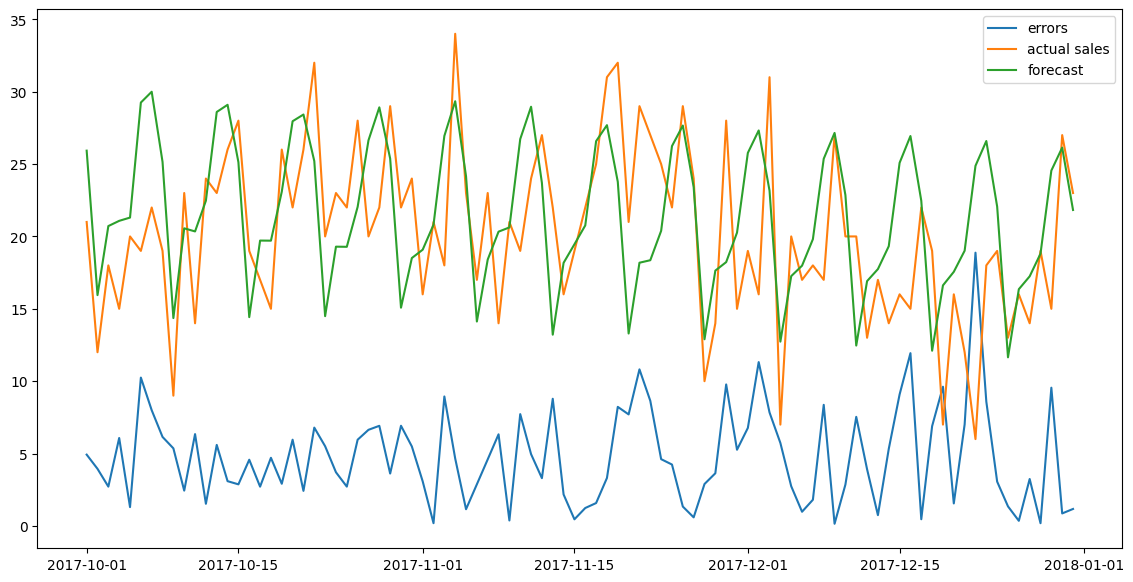

In [38]:
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')

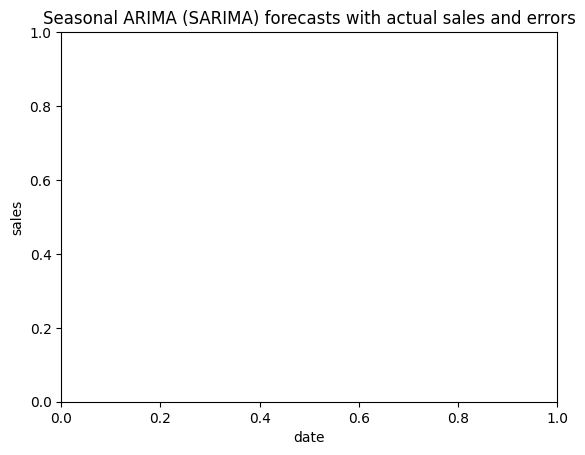

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1861.0,1973.197447,-112.197447,4.799933,5.839147,23.728846


In [39]:
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_sarima

In [40]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1.0,1.0,13.0,2013,1,1,1
1,2013-01-02,1.0,1.0,11.0,2013,1,2,2
2,2013-01-03,1.0,1.0,14.0,2013,1,3,3
3,2013-01-04,1.0,1.0,13.0,2013,1,4,4
4,2013-01-05,1.0,1.0,10.0,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1.0,1.0,14.0,2017,12,27,2
1822,2017-12-28,1.0,1.0,19.0,2017,12,28,3
1823,2017-12-29,1.0,1.0,15.0,2017,12,29,4
1824,2017-12-30,1.0,1.0,27.0,2017,12,30,5


In [41]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)

# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']
reg_test_df = reg_df.loc['2017-10-01':]

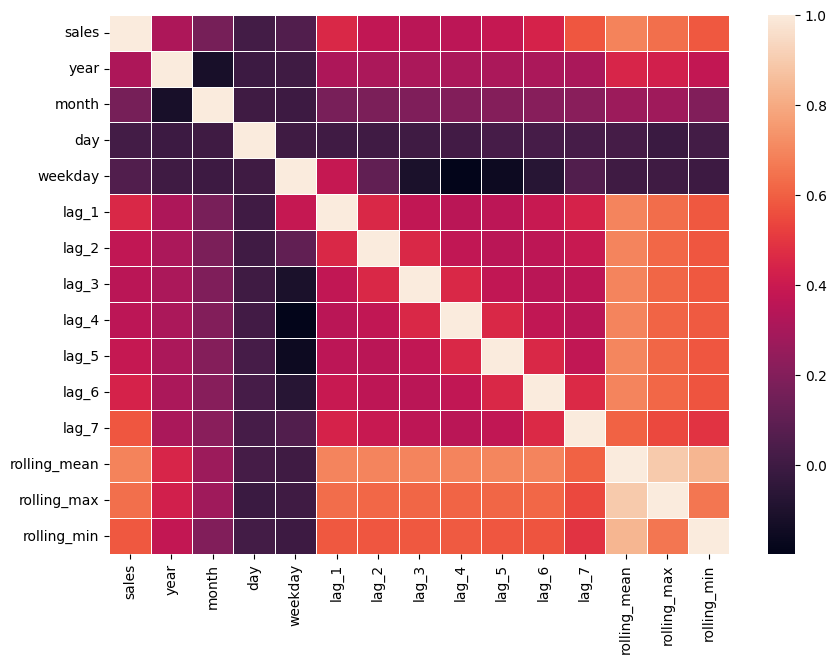

In [42]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [43]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  1577.946956
12   rolling_max  1170.464035
13   rolling_min   888.451268
10         lag_7   860.565955
4          lag_1   449.743115


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

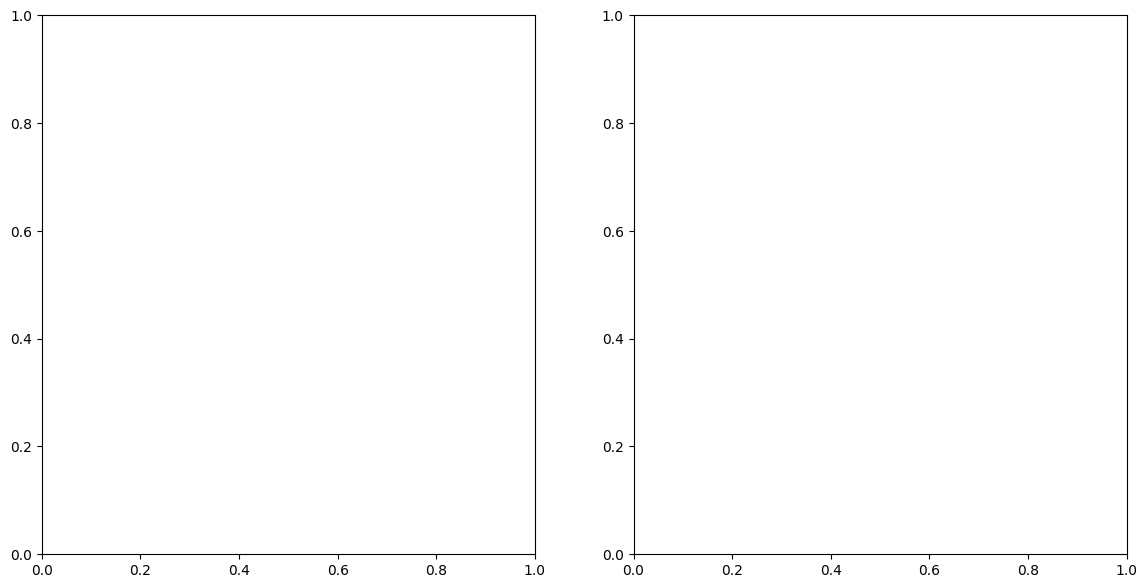

In [44]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_mean, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_df.rolling_max, reg_train_df.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_min, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_df.lag_7, reg_train_df.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [45]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

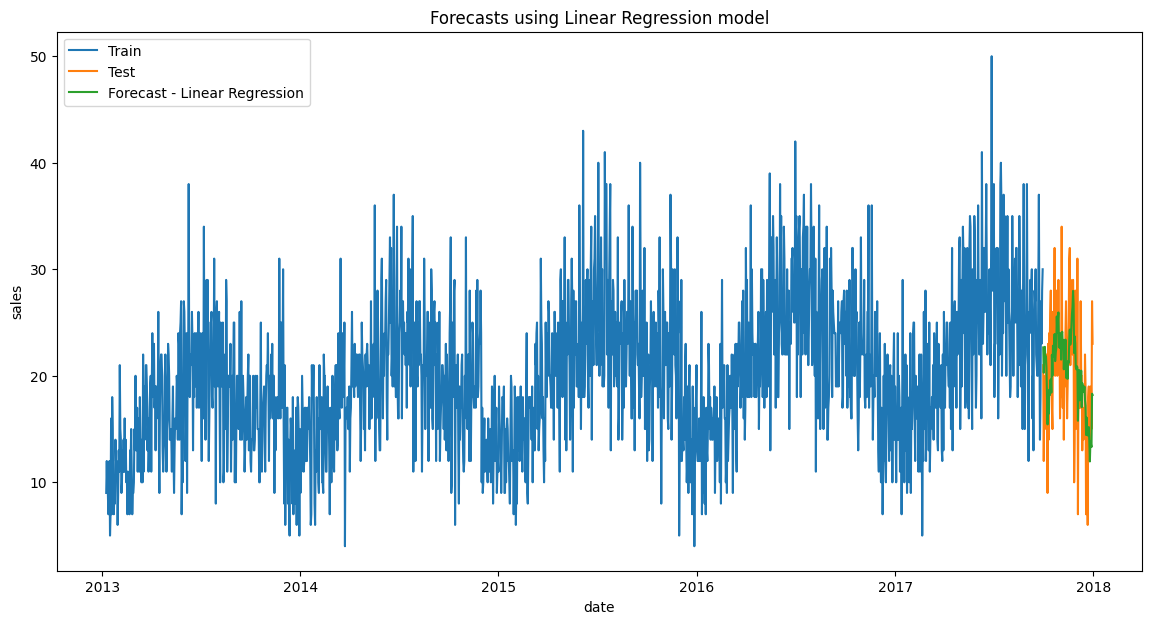

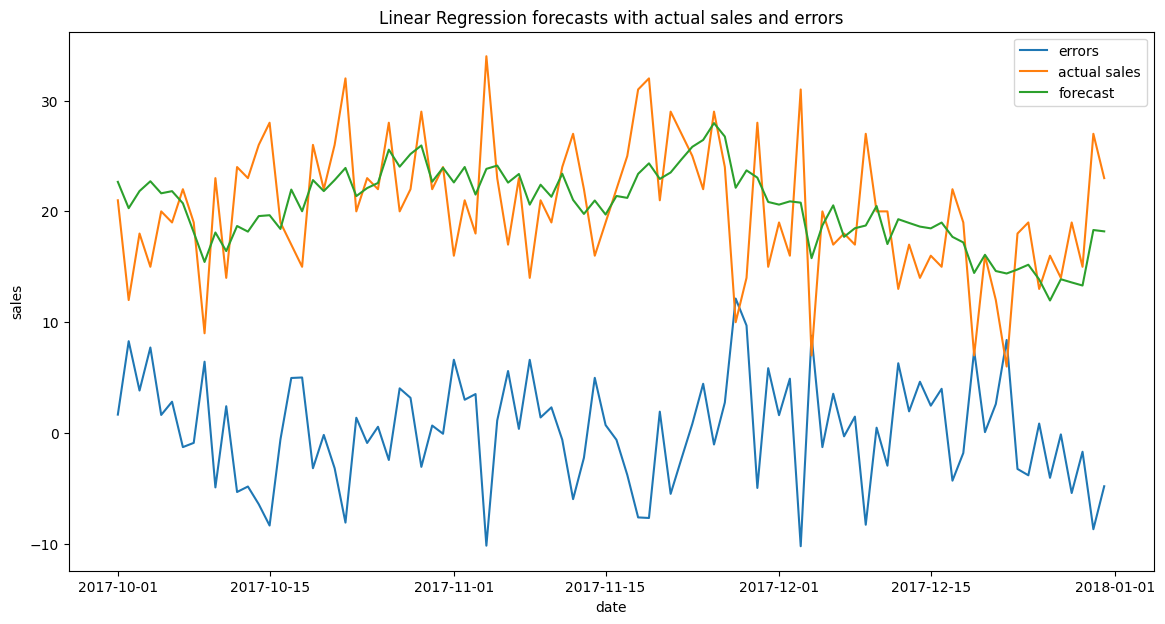

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1861.0,1882.074831,21.074831,3.858646,4.786183,19.075519


In [47]:
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_lr